In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!python3 -m pip install watermark
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,seaborn,tensorflow,matplotlib -a Filippo_Valle -g -r -b -w

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Filippo_Valle 
last updated: Mon Jul 20 2020 

CPython 3.6.9
IPython 5.5.0

pandas 1.0.5
numpy 1.18.5
seaborn 0.10.1
tensorflow 2.2.0
matplotlib 3.2.2

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.104+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   : 
Git repo   : 
Git branch : 
watermark 2.0.2


In [ ]:
import pandas as pd
import numpy as np
import os,sys, gc
import matplotlib.pyplot as plt
!pip install --extra-index https://test.pypi.org/simple pandarallel topicpy
from topicpy.hsbmpy import get_max_available_L

os.environ["TF_CUDNN_USE_AUTOTUNE"]="0" #to avoid Nvidia GPU warming up

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
algorithm = "topsbm"
directory='/content/drive/My Drive/phd/datasets/merged'
L = get_max_available_L(directory, algorithm)-2
os.chdir(directory)

In [ ]:
label = 'status'

df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L)).set_index('doc').drop('i_doc', axis=1)
df_words = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,L), index_col=0)
df_words.index=[g[:15] for g in df_words.index]
df = pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index)
df = df.divide(df.sum(0),1).transpose().fillna(0)
df_files=pd.read_csv("files.dat", index_col=0)
df_topics.insert(0,'tissue', df_files.reindex(index=df_topics.index)[label])
df_topic_tissue = df_topics.groupby('tissue').mean()
df_files.head()

,primary_site,status,dataset,tissue_hd
TCGA-E8-A2JQ-11A-11R-A180-07,Thyroid,healthy,tcga,Thyroid_healthy
TCGA-EL-A3ZK-11A-11R-A23N-07,Thyroid,healthy,tcga,Thyroid_healthy
TCGA-BJ-A28X-11A-11R-A22L-07,Thyroid,healthy,tcga,Thyroid_healthy
TCGA-BJ-A28R-11A-11R-A16R-07,Thyroid,healthy,tcga,Thyroid_healthy
TCGA-EL-A3T8-11A-11R-A22L-07,Thyroid,healthy,tcga,Thyroid_healthy


## Predictor

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy,mean_squared_error, categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.python.client.device_lib import list_local_devices
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os,sys, gc
list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 928165133123643291, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4739731931524175697
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16383895747442120170
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3208630261909173479
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [ ]:
df_labels=df_files.copy()
df_labels=df_labels.reindex(index=df_topics.index)

uniq = len(df_labels[label].unique())

X_train = df_topics.drop('tissue',1)
X_train = X_train.subtract(X_train.mean(0),1).divide(0.5*(X_train.max(0)-X_train.min(0)),1).values.astype(float) #SGD transform
Y_train = to_categorical(np.unique(df_labels[label], return_inverse=True)[1])
inputs = X_train.shape[1]

if uniq==2: #hidden=(1941,100), bs=50 
  Y_train = np.argmax(Y_train, axis=-1)
  uniq = 1
  activation_func = "sigmoid"
  lr = 0.01
  bs = 50
  momentum = 0.9
  l1 = 0.01
  l2 = 0.0001
  loss=binary_crossentropy
else: #hidden (1941,100), bs=500, l1=0.001, l2=1e-9
  activation_func = "softmax"
  lr = 0.03
  bs = 500
  momentum = 0.95
  l1 = 0.001
  l2 = 1e-9
  loss=categorical_crossentropy


classes=np.unique(df_labels[df_labels.index.isin(df.index)][label], return_inverse=True)[0]

X_tm_train, X_tm_test, Y_tm_train, Y_tm_test = train_test_split(X_train, Y_train, random_state=42, train_size=0.95)

print(uniq, X_train.shape, Y_train.shape, X_tm_train.shape, Y_tm_train.shape)

1 (800, 1941) (800,) (760, 1941) (760,)


# K-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

class KNNClassifier(KNeighborsClassifier):
    def __init__(self, n_neighbors=10, **kwargs):
        super().__init__(n_neighbors, **kwargs)

    def fit(self,  X, y):
        return super().fit(X, y)

    def evaluate(self, X, Y):
        Y_pred = self.predict(X)
        if tf.cast(tf.round(tf.reduce_max(Y)),tf.int64) > tf.constant(1, dtype=tf.int64):
            Y = to_categorical(Y)
            Y_pred = to_categorical(Y_pred)
        acc = accuracy_score(Y, Y_pred)
        auc = roc_auc_score(Y, Y_pred, average="weighted", multi_class="ovr")
        print(f"Accuracy: {acc}, AUC:{auc}")
        return [acc, auc]

def fit_knn(X_knn_train, X_knn_test, Y_knn_train, Y_knn_test):
    X_pj_train, X_pj_test, Y_pj_train, Y_pj_test = list(map(tf.convert_to_tensor, (X_knn_train, X_knn_test, Y_knn_train, Y_knn_test)))
    print(uniq, X_knn_train.shape, Y_knn_train.shape, X_knn_test.shape, Y_knn_test.shape, Y_knn_train[0])
    import time
    with tf.device("GPU"):
        model_knn = KNNClassifier(n_neighbors=5, n_jobs=4, metric="euclidean")
        model_knn.fit(X_knn_train, Y_knn_train)
        model_knn.evaluate(X_knn_test, Y_knn_test)

X_knn_train, X_knn_test, Y_knn_train, Y_knn_test = train_test_split(df.values, np.unique(df_files.reindex(index=df.index)[label], return_inverse=True)[1], random_state=42, train_size=0.8)
fit_knn(X_knn_train, X_knn_test, Y_knn_train, Y_knn_test)

X_knn_train, X_knn_test, Y_knn_train, Y_knn_test = train_test_split(pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index).fillna(0).applymap(lambda tpm: np.log2(tpm+1)).values.T, np.unique(df_files.reindex(index=df.index)[label], return_inverse=True)[1], random_state=42, train_size=0.8)
fit_knn(X_knn_train, X_knn_test, Y_knn_train, Y_knn_test)

X_knn_train, X_knn_test, Y_knn_train, Y_knn_test = train_test_split(X_train, Y_train, random_state=42, train_size=0.8)
fit_knn(X_knn_train, X_knn_test, Y_knn_train, Y_knn_test)

model_knn = KNNClassifier(n_neighbors=5, n_jobs=4, metric="euclidean")
model_knn.fit(X_knn_train, Y_knn_train)
model_knn.evaluate(X_knn_test, Y_knn_test)


1 (640, 3000) (640,) (160, 3000) (160,) 0
Accuracy: 0.8375, AUC:0.837722185648453
1 (640, 3000) (640,) (160, 3000) (160,) 0
Accuracy: 0.9875, AUC:0.9838709677419355
1 (640, 1941) (640,) (160, 1941) (160,) 0
Accuracy: 0.9125, AUC:0.890059249506254
Accuracy: 0.9125, AUC:0.890059249506254


[0.9125, 0.890059249506254]

# Neural Net

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               194200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 194,301
Trainable params: 194,301
Non-trainable params: 0
_________________________________________________________________
None


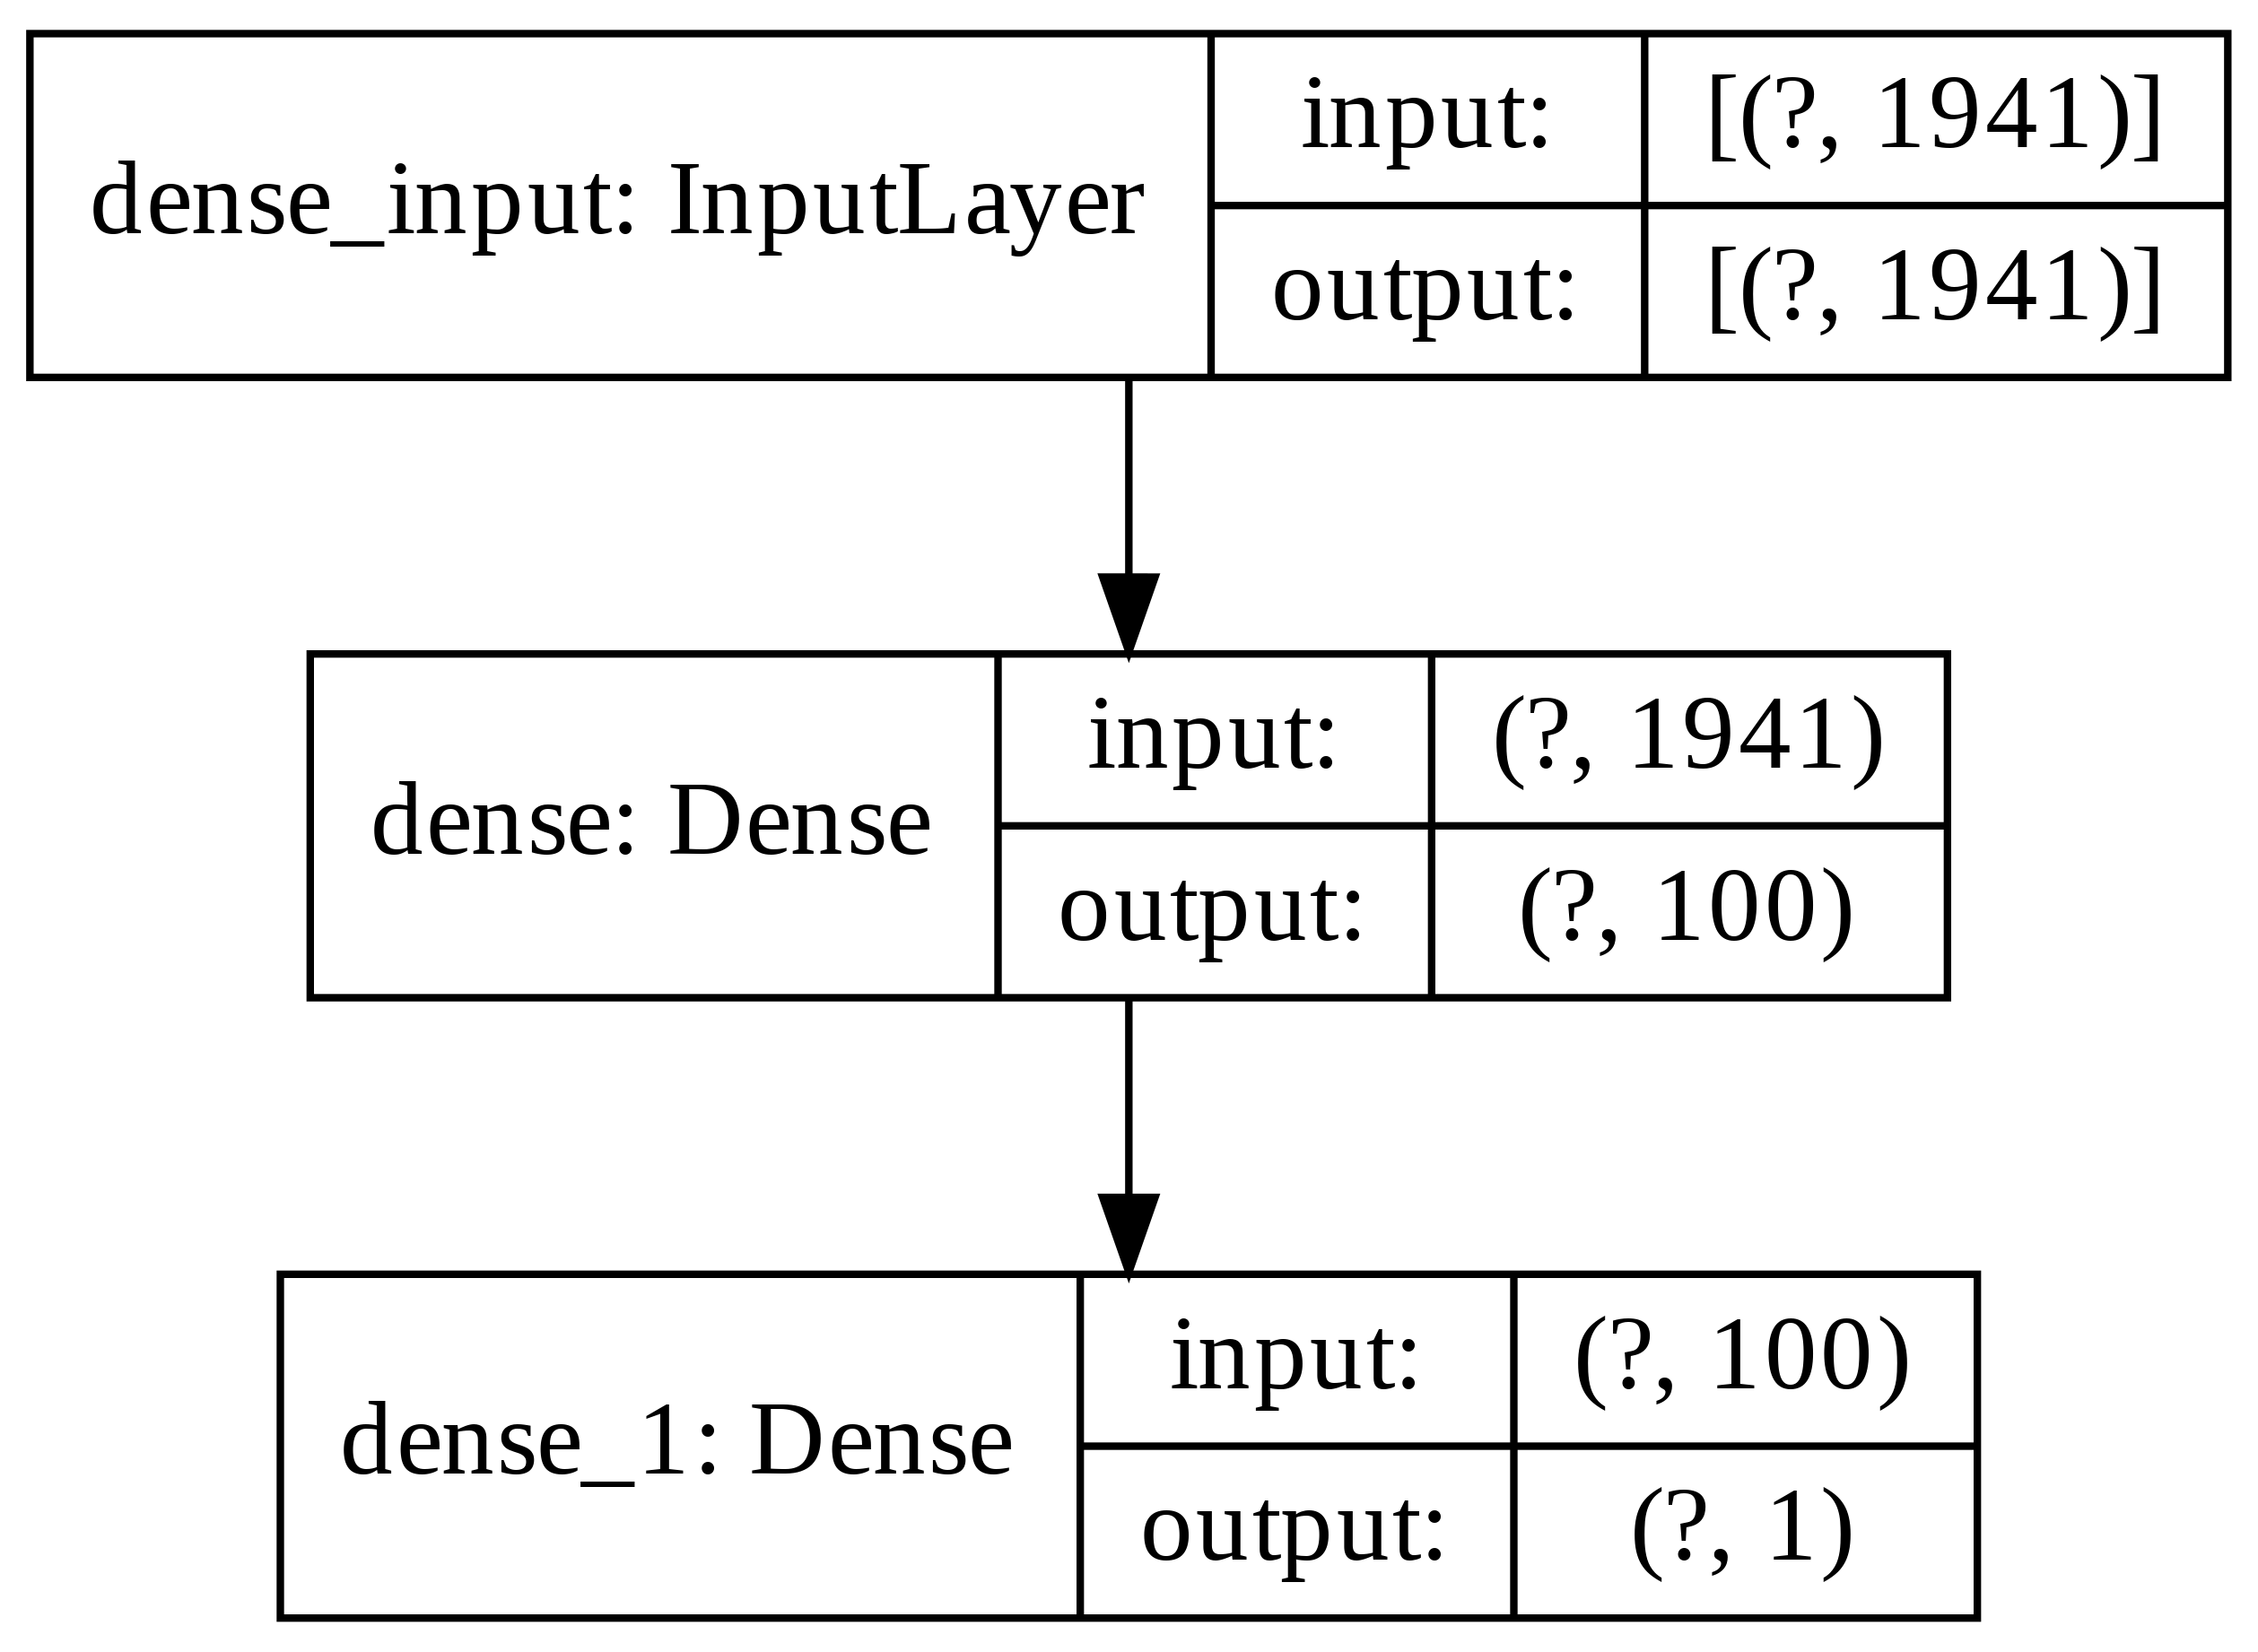

In [ ]:
K.clear_session()

os.system("rm -rf log.csv")
csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, mode='min', patience=25)

model=Sequential()
model.add(Dense(units=100, input_dim=inputs, use_bias=True, bias_initializer="ones", activation="relu", kernel_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=uniq, activation=activation_func))
model.compile(loss=loss, optimizer=SGD(lr=lr, momentum=momentum), metrics=['accuracy', 'AUC'])
K.set_learning_phase(0)

print(model.summary())
plot_model(model, to_file=f"model_{label}.png", dpi=600, show_shapes=True)


In [ ]:
with tf.device("GPU"):
    model.fit(X_tm_train, Y_tm_train, epochs=1000, batch_size=bs, verbose=1, validation_split=0.25, callbacks=[csv_logger, es], shuffle=True, use_multiprocessing=True, workers=-1)

Epoch 1/1000
12/12 [==============================] - 0s 24ms/step - loss: 50.0027 - accuracy: 0.6947 - auc: 0.7533 - val_loss: 43.0535 - val_accuracy: 0.7526 - val_auc: 0.9596
Epoch 2/1000
12/12 [==============================] - 0s 7ms/step - loss: 36.3002 - accuracy: 0.8649 - auc: 0.9496 - val_loss: 27.6031 - val_accuracy: 0.8737 - val_auc: 0.9919
Epoch 3/1000
12/12 [==============================] - 0s 6ms/step - loss: 21.6483 - accuracy: 0.9246 - auc: 0.9791 - val_loss: 14.6314 - val_accuracy: 0.9842 - val_auc: 0.9980
Epoch 4/1000
12/12 [==============================] - 0s 6ms/step - loss: 10.5343 - accuracy: 0.9509 - auc: 0.9907 - val_loss: 6.1351 - val_accuracy: 0.9789 - val_auc: 0.9984
Epoch 5/1000
12/12 [==============================] - 0s 6ms/step - loss: 4.1662 - accuracy: 0.9561 - auc: 0.9886 - val_loss: 2.5323 - val_accuracy: 0.8842 - val_auc: 0.9962
Epoch 6/1000
12/12 [==============================] - 0s 6ms/step - loss: 2.1788 - accuracy: 0.8421 - auc: 0.9301 - val_lo

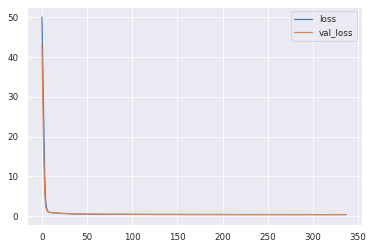

In [ ]:
pd.read_csv("log.csv", sep=",")[['loss','val_loss']].plot()

In [ ]:
model.evaluate(X_tm_test, Y_tm_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.4015 - accuracy: 0.9750 - auc: 1.0000


[0.4015139639377594, 0.9750000238418579, 1.0]

In [ ]:
#model.save(f"model_{label}.h5")
model = load_model(f"model_{label}.h5")
print(model.summary())
#plot_model(model, to_file=f"model_{label}.png", dpi=600, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               194200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 194,301
Trainable params: 194,301
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
gc.collect()

10174

# evaluate on non used on topsbm training


In [ ]:
df_test_table = pd.read_csv("mainTable_test.csv", index_col = 0)
df_test_table = df_test_table.where(df_test_table<1e5,1e5)

In [ ]:
#project only HV genes
df_topic_test = df_test_table.reindex(index=df_words.index)
df_topic_test = df_topic_test.transpose().fillna(-1).astype(int)

df_topic_test = pd.DataFrame(data=np.matmul(df_topic_test.values,df_words.values), index=df_topic_test.index, columns=df_words.columns)
df_test=df_topic_test.divide(df_topic_test.mean(axis=0), axis=1) #normalize P(t|d)

df_test = df_test.subtract(df_topics.drop("tissue",1).mean(0),1).divide((X_train.max(0)-X_train.min(0)),1) #SGD transform

In [ ]:
classes = np.unique(df_files.reindex(index=df_test.index)[label])
X_test = df_test.values.astype(float)
Y_test = to_categorical([np.where(classes==t)[0][0] for t in df_files.reindex(index=df_test.index)[label].values.ravel()])
if uniq==1:
  Y_test = np.argmax(Y_test, axis=-1)
  uniq=1
#np.savetxt("classes.txt", classes, fmt="%s")
#np.savetxt("X_test.txt", X_test)
#np.savetxt("Y_test.txt", Y_test)

In [ ]:
with tf.device("GPU"):
    model.evaluate(X_test, Y_test, verbose=2, workers=-1, use_multiprocessing=True)
    if uniq ==1:
        model_knn.evaluate(tf.convert_to_tensor(df_topic_test), tf.convert_to_tensor(Y_test))
    else:
        model_knn.evaluate(tf.convert_to_tensor(df_topic_test), tf.convert_to_tensor(Y_test))

161/161 - 0s - loss: 0.7800 - accuracy: 0.9474 - auc_1: 0.9762
Accuracy: 0.9226271681933347, AUC:0.926799862324638


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
y_pred_p = model.predict(X_test)
if uniq>1:
  y_true = np.argmax(Y_test,axis=-1)
  y_pred = np.argmax(y_pred_p,axis=-1)
else:
  y_pred_p = y_pred_p.ravel()
  y_true = Y_test
  y_pred = np.ones(y_pred_p.shape)
  y_pred[y_pred_p<0.5]=0
results = confusion_matrix(y_true, y_pred, normalize="true")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


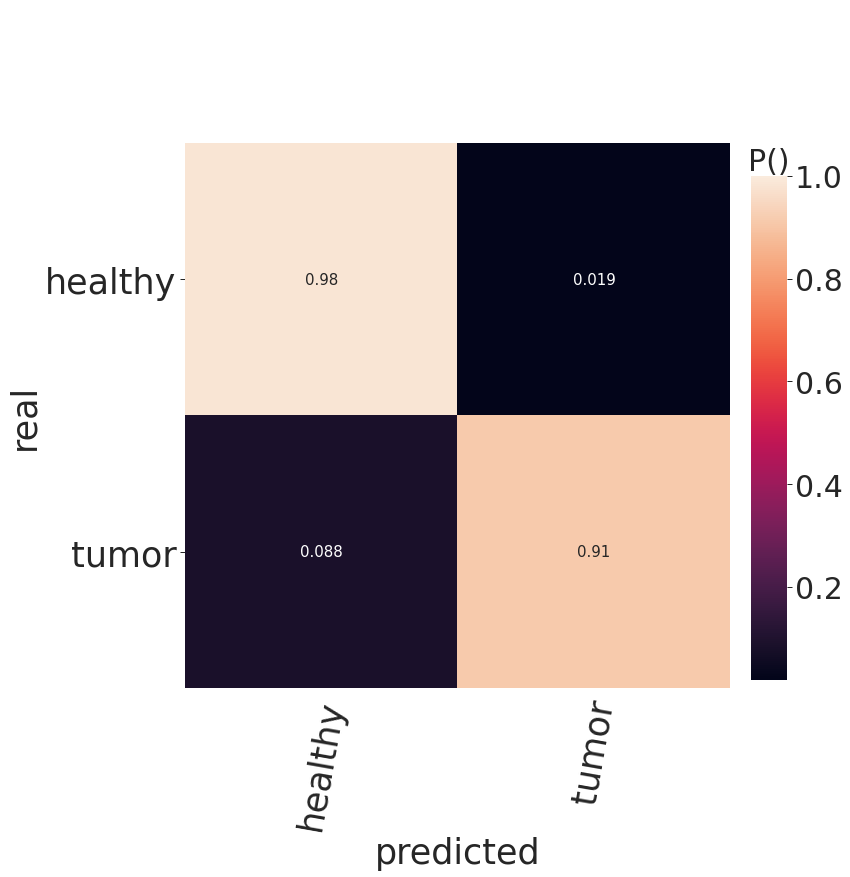

In [ ]:
cm = sns.clustermap(results, 
                    vmax=1,  
                    row_cluster=False, 
                    col_cluster=False, 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    annot=False,
                    annot_kws={"fontsize":15},
                    cbar_pos=(0.99,0.05,0.05,0.7))
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("real", fontsize=35, rotation=90)
ax.set_yticklabels(labels=classes, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=classes, rotation=80)
ax.set_xlabel("predicted",fontsize=35)
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("P()", fontsize=30)
plt.tight_layout()
cm.savefig(f"predict_{label}.pdf")

plt.show()

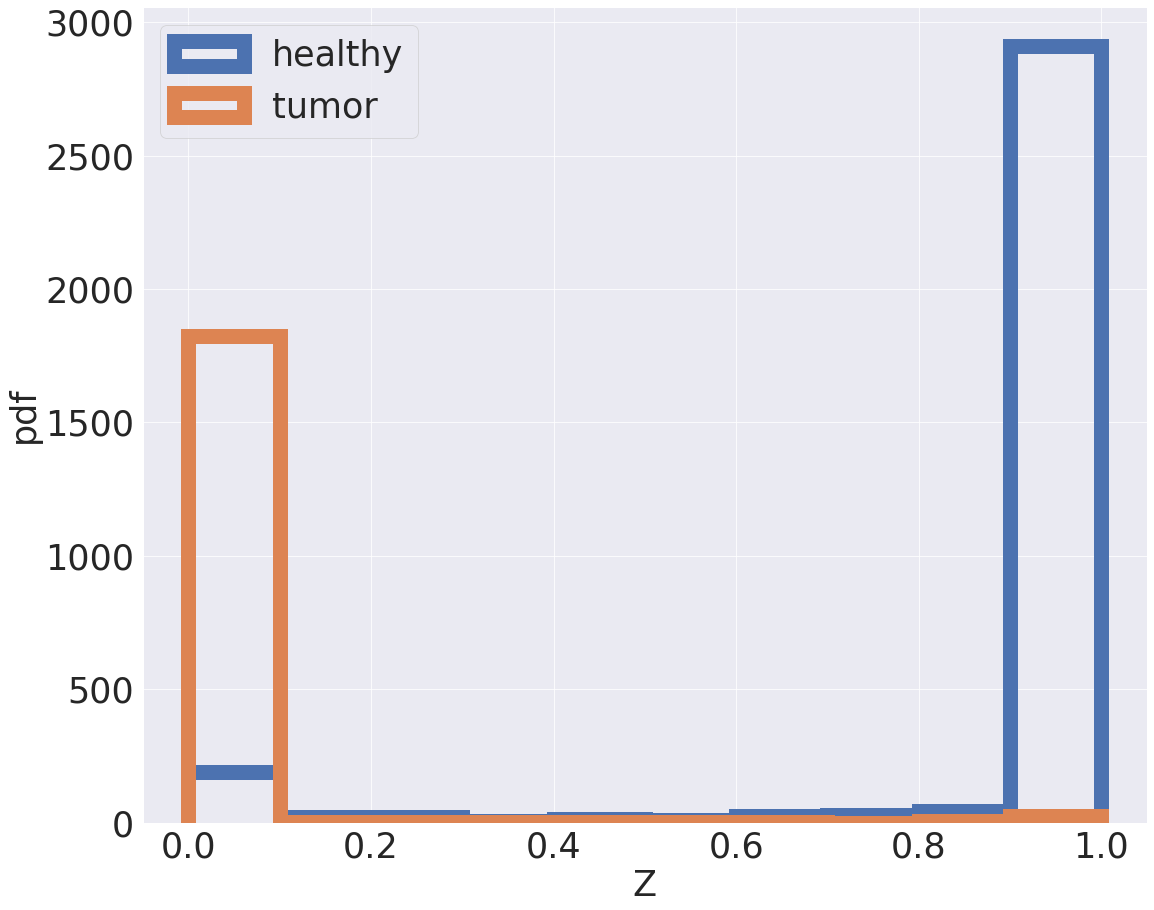

In [ ]:
fig, ax= plt.subplots(figsize=(18,15))

if uniq > 1:
  for c in range(uniq):
    ax.hist((1-model.predict(X_test).T[0])[Y_test.argmax(1)==c], histtype="step", lw=15, bins=10, density=True)
else:
  ax.hist(y_pred_p[Y_test==1], histtype="step", lw=15, bins=10, density=False, label="healthy")
  ax.hist(y_pred_p[Y_test==0], histtype="step", lw=15, bins=10, density=False, label="tumor")

ax.tick_params(labelsize=35)
ax.legend(fontsize=35, loc="upper left")
ax.set_title("", fontsize=35)

ax.set_xlim(-0.05,1.05)

ax.set_xlabel("Z", fontsize=35)
ax.set_ylabel("pdf", fontsize=35)

plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_p)
#fpr, tpr, thresholds = roc_curve(Y_train, model.predict(X_train))

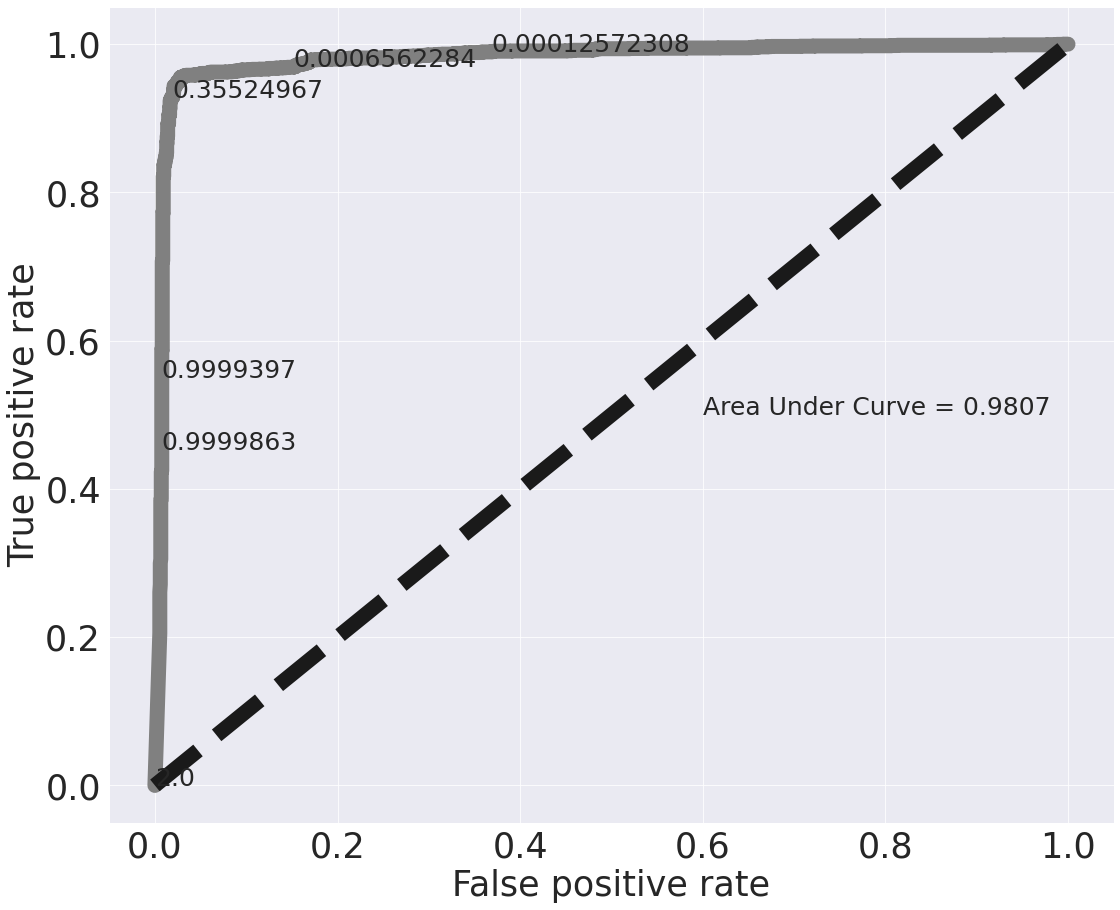

In [ ]:
fig, ax = plt.subplots(figsize=(18,15))

ax.plot(fpr,tpr, c="gray", lw=15)

ax.plot([0, 1], [0, 1], 'k--', lw=15)
ax.set_xlabel('False positive rate', fontsize=35)
ax.set_ylabel('True positive rate', fontsize=35)


for f, t, thr in zip(fpr[::100], tpr[::100], thresholds[::100]):
    ax.annotate(thr, (f, t), fontsize=25)

ax.annotate("Area Under Curve = %.4f"%roc_auc_score(y_true, y_pred_p), xy=(0.6, 0.5), fontsize=25)

ax.tick_params(labelsize=35)

plt.show()
fig.savefig(f"roc_{label}.pdf")